In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import os as os
import sys as sys
import glob as glob
import re as re
import numpy as np
import shutil as shutil

import paprika
print(paprika.__version__)

from paprika.analysis import fe_calc
from paprika.restraints import DAT_restraint

import pytraj as pt
import parmed as pmd

2018-04-25_11:36:18_-0700-d9c5b14-0.0.3


In [2]:
import logging
from importlib import reload
reload(logging)

logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%Y-%m-%d %I:%M:%S %p',
                    level=logging.DEBUG)
logging.info('Started logging...')

2018-04-25 11:39:52 AM Started logging...


In [3]:
dummy_anchors = [':3', ':4', ':5']
host_anchors  = [':1@C26', ':1@C18', ':1@C8']
guest_anchors = [':2@C6', ':2@C1']

In [4]:
attach_string = '0.00 0.40 0.80 1.60 2.40 4.00 5.50 8.65 11.80 ' \
                '18.10 24.40 37.00 49.60 74.80 100.00'
attach_fractions = [float(i) / 100 for i in attach_string.split()]

pull_string = '0.00 0.40 0.80 1.20 1.60 2.00 2.40 2.80 3.20 3.60 4.00 ' \
              '4.40 4.80 5.20 5.60 6.00 6.40 6.80 7.20 7.60 8.00 8.40 ' \
              '8.80 9.20 9.60 10.00 10.40 10.80 11.20 11.60 12.00 12.40 ' \
              '12.80 13.20 13.60 14.00 14.40 14.80 15.20 15.60 16.00 16.40 ' \
              '16.80 17.20 17.60 18.00'

windows = [len(attach_fractions), len(pull_string.split()), 0]

In [5]:
paths = glob.glob(os.path.normpath(os.path.join('./OA-G6-0', 'AMBER', 'APR', 'windows', '*')))

window_list = [os.path.basename(i) for i in paths]
phase_dict = {'a': 'attach', 'p': 'pull', 'r': 'release'}

In [6]:
g6_complexes = glob.glob('./OA-G6*')
complx = 'OA-G6-0'

In [7]:
traj = pt.load(os.path.join(complx, 'AMBER', 'solvate.rst7'), 
                os.path.join(complx, 'AMBER', 'solvate.prmtop'))

pull_initial = pt.distance(traj, ' '.join([dummy_anchors[0], guest_anchors[0]]))[0]

print(f'Set pull offset ({pull_initial:1.2f} A)')

pull_distances = [float(i) + pull_initial for i in pull_string.split()]

guest_restraint_atoms = [[dummy_anchors[0], guest_anchors[0]],
                     [dummy_anchors[1], dummy_anchors[0], guest_anchors[0]],
                     [dummy_anchors[0], guest_anchors[0], guest_anchors[1]],
                    ]

guest_restraint_targets = [pull_initial,
                           180.0,
                           180.0
                          ]
guest_restraint_target_final = [pull_distances[-1], 180.0, 180.0]
guest_restraint_distance_fc = 5.0 # kcal/mol-A**2
guest_restraint_angle_fc = 100.0  # kcal/mol-rad**2

hg = pmd.load_file(os.path.join(complx, 'AMBER', 'solvate.prmtop'),
               os.path.join(complx, 'AMBER', 'solvate.rst7'),
               structure=True)

guest_restraints = []
for index, atoms in enumerate(guest_restraint_atoms): 
    if len(atoms) > 2:
        angle = True
    else:
        angle = False
    this = DAT_restraint()
    this.auto_apr = True
    this.amber_index = True
    this.topology = hg
    this.mask1 = atoms[0]
    this.mask2 = atoms[1]
    if angle:
        this.mask3 = atoms[2]
        this.attach['fc_final'] = guest_restraint_angle_fc
    else:
        this.attach['fc_final'] = guest_restraint_distance_fc
    this.attach['target'] = guest_restraint_targets[index]
    this.attach['fraction_list'] = attach_fractions

    this.pull['target_final'] = guest_restraint_target_final[index]
    this.pull['num_windows'] = windows[1]
    this.initialize()

    guest_restraints.append(this)

structure = pt.load(os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.rst7'), 
                   os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.prmtop'))

stripped = structure.strip(':WAT,:Na+,:Cl-')

Set pull offset (9.98 A)


2018-04-25 11:39:54 AM Calculating attach targets and force constants...
2018-04-25 11:39:54 AM Attach, Method #3
2018-04-25 11:39:54 AM Calculating pull targets and force constants...
2018-04-25 11:39:54 AM Pull, Method #1
2018-04-25 11:39:54 AM Calculating release targets and force constants...
2018-04-25 11:39:54 AM No restraint info set for the release phase! Skipping...
2018-04-25 11:39:54 AM Number of attach windows = 15
2018-04-25 11:39:54 AM Number of pull windows = 46
2018-04-25 11:39:54 AM This restraint will be skipped in the release phase
2018-04-25 11:39:54 AM Assigning atom indices...
2018-04-25 11:39:54 AM There are 1 atoms in the mask :3  ...
2018-04-25 11:39:54 AM There are 1 atoms in the mask :2@C6  ...
2018-04-25 11:39:54 AM Calculating attach targets and force constants...
2018-04-25 11:39:54 AM Attach, Method #3
2018-04-25 11:39:54 AM Calculating pull targets and force constants...
2018-04-25 11:39:54 AM Pull, Method #1
2018-04-25 11:39:54 AM Calculating release ta

In [8]:
from paprika.analysis import read_restraint_data

In [9]:
read_restraint_data(guest_restraints[0], 
                    window=os.path.join(complx, 'AMBER', 'APR','windows', 'a000'),
                   trajectory='prod*',
                   prmtop=stripped.topology,
                   single_prmtop=True,
                   fraction=1.0)

2018-04-25 11:39:55 AM Reading restraint data for OA-G6-0/AMBER/APR/windows/a000...


array([ 11.01921048,  10.77825747,  10.84124505, ...,  11.38297258,
        11.14919607,  11.26010068])

In [10]:
read_restraint_data(guest_restraints[0], 
                    window=os.path.join(complx, 'AMBER', 'APR','windows', 'a000'),
                   trajectory='prod*',
                   prmtop=stripped.topology,
                   single_prmtop=True,
                   fraction=0.1)

2018-04-25 11:39:55 AM Reading restraint data for OA-G6-0/AMBER/APR/windows/a000...
2018-04-25 11:39:55 AM Loaded 2000 frames...
2018-04-25 11:39:55 AM Analyzing 200 frames...


array([ 11.01921048,  10.77825747,  10.84124505, ...,  10.22754361,
        10.23912639,   9.78166932])

In [11]:
data = read_restraint_data(guest_restraints[0], 
                    window=os.path.join(complx, 'AMBER', 'APR','windows', 'a000'),
                   trajectory='prod*',
                   prmtop=stripped.topology,
                   single_prmtop=True,
                   fraction=0.1)

print(len(data))

2018-04-25 11:39:56 AM Reading restraint data for OA-G6-0/AMBER/APR/windows/a000...
2018-04-25 11:39:56 AM Loaded 2000 frames...
2018-04-25 11:39:56 AM Analyzing 200 frames...


200


In [33]:
fecalc = fe_calc()
fecalc.prmtop = stripped.topology
fecalc.trajectory = 'prod.*.nc'
fecalc.path = os.path.join(complx, 'AMBER', 'APR','windows')
fecalc.restraint_list = guest_restraints
fecalc.collect_data(fraction=1.0)
fecalc.compute_free_energy()

print(f"{fecalc.results['attach']['mbar-block']['fe']} {fecalc.results['pull']['mbar-block']['fe']}")

2018-04-25 11:46:23 AM Replacing OA-G6-0/AMBER/APR/windows/a014 with OA-G6-0/AMBER/APR/windows/p000 in ['OA-G6-0/AMBER/APR/windows/a000', 'OA-G6-0/AMBER/APR/windows/a001', 'OA-G6-0/AMBER/APR/windows/a002', 'OA-G6-0/AMBER/APR/windows/a003', 'OA-G6-0/AMBER/APR/windows/a004', 'OA-G6-0/AMBER/APR/windows/a005', 'OA-G6-0/AMBER/APR/windows/a006', 'OA-G6-0/AMBER/APR/windows/a007', 'OA-G6-0/AMBER/APR/windows/a008', 'OA-G6-0/AMBER/APR/windows/a009', 'OA-G6-0/AMBER/APR/windows/a010', 'OA-G6-0/AMBER/APR/windows/a011', 'OA-G6-0/AMBER/APR/windows/a012', 'OA-G6-0/AMBER/APR/windows/a013', 'OA-G6-0/AMBER/APR/windows/a014'] for `continuous_apr`...
2018-04-25 11:46:23 AM Reading restraint data for OA-G6-0/AMBER/APR/windows/a000...
2018-04-25 11:46:23 AM Reading restraint data for OA-G6-0/AMBER/APR/windows/a001...
2018-04-25 11:46:23 AM Reading restraint data for OA-G6-0/AMBER/APR/windows/a002...
2018-04-25 11:46:23 AM Reading restraint data for OA-G6-0/AMBER/APR/windows/a003...
2018-04-25 11:46:23 AM Rea

0.6361760121400574 9.890174438747101


In [76]:
for fraction in np.arange(0.1, 1.1, 0.1):
    fecalc = fe_calc()
    fecalc.prmtop = stripped.topology
    fecalc.trajectory = 'prod.*.nc'
    fecalc.path = os.path.join(complx, 'AMBER', 'APR','windows')
    fecalc.restraint_list = guest_restraints
    fecalc.collect_data(fraction=fraction)
    fecalc.compute_free_energy()

    print(f"{fecalc.results['attach']['mbar-block']['fe']} {fecalc.results['pull']['mbar-block']['fe']}")

2018-04-25 02:05:08 PM Replacing OA-G6-0/AMBER/APR/windows/a014 with OA-G6-0/AMBER/APR/windows/p000 in ['OA-G6-0/AMBER/APR/windows/a000', 'OA-G6-0/AMBER/APR/windows/a001', 'OA-G6-0/AMBER/APR/windows/a002', 'OA-G6-0/AMBER/APR/windows/a003', 'OA-G6-0/AMBER/APR/windows/a004', 'OA-G6-0/AMBER/APR/windows/a005', 'OA-G6-0/AMBER/APR/windows/a006', 'OA-G6-0/AMBER/APR/windows/a007', 'OA-G6-0/AMBER/APR/windows/a008', 'OA-G6-0/AMBER/APR/windows/a009', 'OA-G6-0/AMBER/APR/windows/a010', 'OA-G6-0/AMBER/APR/windows/a011', 'OA-G6-0/AMBER/APR/windows/a012', 'OA-G6-0/AMBER/APR/windows/a013', 'OA-G6-0/AMBER/APR/windows/a014'] for `continuous_apr`...
2018-04-25 02:05:08 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a000...
2018-04-25 02:05:08 PM Loaded 2000 frames...
2018-04-25 02:05:08 PM Analyzing 200 frames...
2018-04-25 02:05:08 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a001...
2018-04-25 02:05:08 PM Loaded 2000 frames...
2018-04-25 02:05:08 PM Analyzing 200 frames...
2018-04-25

0.642902913250052 9.197567880940163


2018-04-25 02:05:12 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a013...
2018-04-25 02:05:12 PM Loaded 4000 frames...
2018-04-25 02:05:12 PM Analyzing 800 frames...
2018-04-25 02:05:12 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/p000...
2018-04-25 02:05:12 PM Loaded 2000 frames...
2018-04-25 02:05:12 PM Analyzing 400 frames...
2018-04-25 02:05:12 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/p000...
2018-04-25 02:05:12 PM Loaded 2000 frames...
2018-04-25 02:05:12 PM Analyzing 400 frames...
2018-04-25 02:05:12 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/p001...
2018-04-25 02:05:12 PM Loaded 2000 frames...
2018-04-25 02:05:12 PM Analyzing 400 frames...
2018-04-25 02:05:12 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/p002...
2018-04-25 02:05:12 PM Loaded 6000 frames...
2018-04-25 02:05:12 PM Analyzing 1200 frames...
2018-04-25 02:05:12 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/p003...
2018-04-25 02:05:12 PM Loaded 6000 

0.6445230573590549 10.051517004786097


2018-04-25 02:05:18 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a010...
2018-04-25 02:05:18 PM Loaded 4000 frames...
2018-04-25 02:05:18 PM Analyzing 1200 frames...
2018-04-25 02:05:18 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a011...
2018-04-25 02:05:18 PM Loaded 4000 frames...
2018-04-25 02:05:18 PM Analyzing 1200 frames...
2018-04-25 02:05:18 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a012...
2018-04-25 02:05:18 PM Loaded 4000 frames...
2018-04-25 02:05:18 PM Analyzing 1200 frames...
2018-04-25 02:05:18 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a013...
2018-04-25 02:05:18 PM Loaded 4000 frames...
2018-04-25 02:05:18 PM Analyzing 1200 frames...
2018-04-25 02:05:18 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/p000...
2018-04-25 02:05:18 PM Loaded 2000 frames...
2018-04-25 02:05:18 PM Analyzing 600 frames...
2018-04-25 02:05:18 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/p000...
2018-04-25 02:05:18 PM Loaded 20

0.6492368645358476 10.358204668884719


2018-04-25 02:05:27 PM Analyzing 1600 frames...
2018-04-25 02:05:27 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a009...
2018-04-25 02:05:27 PM Loaded 4000 frames...
2018-04-25 02:05:27 PM Analyzing 1600 frames...
2018-04-25 02:05:27 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a010...
2018-04-25 02:05:27 PM Loaded 4000 frames...
2018-04-25 02:05:27 PM Analyzing 1600 frames...
2018-04-25 02:05:27 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a011...
2018-04-25 02:05:27 PM Loaded 4000 frames...
2018-04-25 02:05:27 PM Analyzing 1600 frames...
2018-04-25 02:05:27 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a012...
2018-04-25 02:05:27 PM Loaded 4000 frames...
2018-04-25 02:05:27 PM Analyzing 1600 frames...
2018-04-25 02:05:27 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a013...
2018-04-25 02:05:27 PM Loaded 4000 frames...
2018-04-25 02:05:27 PM Analyzing 1600 frames...
2018-04-25 02:05:27 PM Reading restraint data for OA-G6-0/AMBER/APR

0.644151119661185 10.163113173435939


2018-04-25 02:05:37 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a009...
2018-04-25 02:05:37 PM Loaded 4000 frames...
2018-04-25 02:05:37 PM Analyzing 2000 frames...
2018-04-25 02:05:37 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a010...
2018-04-25 02:05:37 PM Loaded 4000 frames...
2018-04-25 02:05:37 PM Analyzing 2000 frames...
2018-04-25 02:05:37 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a011...
2018-04-25 02:05:37 PM Loaded 4000 frames...
2018-04-25 02:05:37 PM Analyzing 2000 frames...
2018-04-25 02:05:37 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a012...
2018-04-25 02:05:37 PM Loaded 4000 frames...
2018-04-25 02:05:37 PM Analyzing 2000 frames...
2018-04-25 02:05:37 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a013...
2018-04-25 02:05:37 PM Loaded 4000 frames...
2018-04-25 02:05:37 PM Analyzing 2000 frames...
2018-04-25 02:05:37 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/p000...
2018-04-25 02:05:37 PM Loaded 2

0.625962694926593 10.096275809351143


2018-04-25 02:05:52 PM Analyzing 2400 frames...
2018-04-25 02:05:52 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a008...
2018-04-25 02:05:52 PM Loaded 4000 frames...
2018-04-25 02:05:52 PM Analyzing 2400 frames...
2018-04-25 02:05:52 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a009...
2018-04-25 02:05:52 PM Loaded 4000 frames...
2018-04-25 02:05:52 PM Analyzing 2400 frames...
2018-04-25 02:05:52 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a010...
2018-04-25 02:05:52 PM Loaded 4000 frames...
2018-04-25 02:05:52 PM Analyzing 2400 frames...
2018-04-25 02:05:52 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a011...
2018-04-25 02:05:52 PM Loaded 4000 frames...
2018-04-25 02:05:52 PM Analyzing 2400 frames...
2018-04-25 02:05:52 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a012...
2018-04-25 02:05:52 PM Loaded 4000 frames...
2018-04-25 02:05:52 PM Analyzing 2400 frames...
2018-04-25 02:05:52 PM Reading restraint data for OA-G6-0/AMBER/APR

0.6321155810150053 9.832045598241567


2018-04-25 02:06:08 PM Analyzing 2800 frames...
2018-04-25 02:06:08 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a007...
2018-04-25 02:06:08 PM Loaded 4000 frames...
2018-04-25 02:06:08 PM Analyzing 2800 frames...
2018-04-25 02:06:08 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a008...
2018-04-25 02:06:08 PM Loaded 4000 frames...
2018-04-25 02:06:08 PM Analyzing 2800 frames...
2018-04-25 02:06:08 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a009...
2018-04-25 02:06:08 PM Loaded 4000 frames...
2018-04-25 02:06:08 PM Analyzing 2800 frames...
2018-04-25 02:06:08 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a010...
2018-04-25 02:06:08 PM Loaded 4000 frames...
2018-04-25 02:06:08 PM Analyzing 2800 frames...
2018-04-25 02:06:08 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a011...
2018-04-25 02:06:08 PM Loaded 4000 frames...
2018-04-25 02:06:08 PM Analyzing 2800 frames...
2018-04-25 02:06:08 PM Reading restraint data for OA-G6-0/AMBER/APR

0.6327210499484115 9.774950631585243


2018-04-25 02:06:26 PM Analyzing 3200 frames...
2018-04-25 02:06:26 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a006...
2018-04-25 02:06:26 PM Loaded 4000 frames...
2018-04-25 02:06:26 PM Analyzing 3200 frames...
2018-04-25 02:06:26 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a007...
2018-04-25 02:06:26 PM Loaded 4000 frames...
2018-04-25 02:06:26 PM Analyzing 3200 frames...
2018-04-25 02:06:26 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a008...
2018-04-25 02:06:26 PM Loaded 4000 frames...
2018-04-25 02:06:26 PM Analyzing 3200 frames...
2018-04-25 02:06:26 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a009...
2018-04-25 02:06:26 PM Loaded 4000 frames...
2018-04-25 02:06:26 PM Analyzing 3200 frames...
2018-04-25 02:06:26 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a010...
2018-04-25 02:06:26 PM Loaded 4000 frames...
2018-04-25 02:06:26 PM Analyzing 3200 frames...
2018-04-25 02:06:26 PM Reading restraint data for OA-G6-0/AMBER/APR

0.6387182279770821 9.807751515903604


2018-04-25 02:06:47 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a005...
2018-04-25 02:06:47 PM Loaded 4000 frames...
2018-04-25 02:06:47 PM Analyzing 3600 frames...
2018-04-25 02:06:47 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a006...
2018-04-25 02:06:47 PM Loaded 4000 frames...
2018-04-25 02:06:48 PM Analyzing 3600 frames...
2018-04-25 02:06:48 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a007...
2018-04-25 02:06:48 PM Loaded 4000 frames...
2018-04-25 02:06:48 PM Analyzing 3600 frames...
2018-04-25 02:06:48 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a008...
2018-04-25 02:06:48 PM Loaded 4000 frames...
2018-04-25 02:06:48 PM Analyzing 3600 frames...
2018-04-25 02:06:48 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a009...
2018-04-25 02:06:48 PM Loaded 4000 frames...
2018-04-25 02:06:48 PM Analyzing 3600 frames...
2018-04-25 02:06:48 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a010...
2018-04-25 02:06:48 PM Loaded 4

0.6380820864216634 9.918930299255528


2018-04-25 02:07:12 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a012...
2018-04-25 02:07:12 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a013...
2018-04-25 02:07:12 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/p000...
2018-04-25 02:07:12 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/p000...
2018-04-25 02:07:12 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/p001...
2018-04-25 02:07:12 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/p002...
2018-04-25 02:07:12 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/p003...
2018-04-25 02:07:12 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/p004...
2018-04-25 02:07:12 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/p005...
2018-04-25 02:07:12 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/p006...
2018-04-25 02:07:12 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/p007...
2018-04-25 02:07:12 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/

0.6361760121400564 9.890174438747472


In [43]:
fractions = np.arange(0.1, 1.1, 0.1)
data = np.zeros((len(fractions), 5))

for index, fraction in enumerate(fractions):
    fecalc = fe_calc()
    fecalc.prmtop = stripped.topology
    fecalc.trajectory = 'prod.*.nc'
    fecalc.path = os.path.join(complx, 'AMBER', 'APR','windows')
    fecalc.restraint_list = guest_restraints
    fecalc.collect_data(fraction=fraction)
    fecalc.compute_free_energy()
    
    data[index, 0] = fraction
    data[index, 1] = fecalc.results['attach']['mbar-block']['fe']
    data[index, 2] = fecalc.results['attach']['mbar-block']['sem']
    data[index, 3] = fecalc.results['pull']['mbar-block']['fe']
    data[index, 4] = fecalc.results['pull']['mbar-block']['sem']

2018-04-25 11:51:36 AM Replacing OA-G6-0/AMBER/APR/windows/a014 with OA-G6-0/AMBER/APR/windows/p000 in ['OA-G6-0/AMBER/APR/windows/a000', 'OA-G6-0/AMBER/APR/windows/a001', 'OA-G6-0/AMBER/APR/windows/a002', 'OA-G6-0/AMBER/APR/windows/a003', 'OA-G6-0/AMBER/APR/windows/a004', 'OA-G6-0/AMBER/APR/windows/a005', 'OA-G6-0/AMBER/APR/windows/a006', 'OA-G6-0/AMBER/APR/windows/a007', 'OA-G6-0/AMBER/APR/windows/a008', 'OA-G6-0/AMBER/APR/windows/a009', 'OA-G6-0/AMBER/APR/windows/a010', 'OA-G6-0/AMBER/APR/windows/a011', 'OA-G6-0/AMBER/APR/windows/a012', 'OA-G6-0/AMBER/APR/windows/a013', 'OA-G6-0/AMBER/APR/windows/a014'] for `continuous_apr`...
2018-04-25 11:51:36 AM Reading restraint data for OA-G6-0/AMBER/APR/windows/a000...
2018-04-25 11:51:36 AM Loaded 2000 frames...
2018-04-25 11:51:36 AM Analyzing 200 frames...
2018-04-25 11:51:36 AM Reading restraint data for OA-G6-0/AMBER/APR/windows/a001...
2018-04-25 11:51:36 AM Loaded 2000 frames...
2018-04-25 11:51:36 AM Analyzing 200 frames...
2018-04-25

In [44]:
data

array([[  0.1       ,   0.64290291,   0.02383743,   9.19756788,
          0.65392908],
       [  0.2       ,   0.64452306,   0.01885507,  10.051517  ,
          0.49850098],
       [  0.3       ,   0.64923686,   0.0204468 ,  10.35820467,
          0.39173291],
       ..., 
       [  0.8       ,   0.63871823,   0.01578531,   9.80775152,
          0.26987643],
       [  0.9       ,   0.63808209,   0.01542485,   9.9189303 ,
          0.25131674],
       [  1.        ,   0.63617601,   0.01405808,   9.89017444,
          0.24261213]])

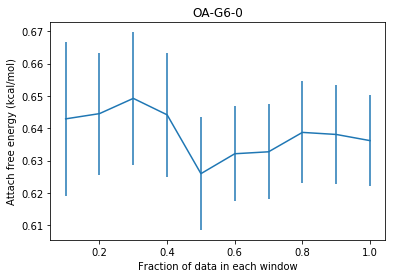

In [48]:
plt.figure()
plt.errorbar(data[:, 0], data[:, 1], yerr=data[:, 2])
plt.ylabel('Attach free energy (kcal/mol)')
plt.xlabel('Fraction of data in each window')
plt.title("OA-G6-0")

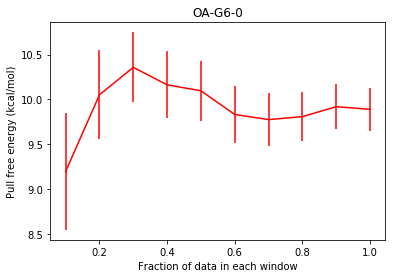

In [49]:
plt.figure()
plt.errorbar(data[:, 0], data[:, 3], yerr=data[:, 4], c='r')
plt.ylabel('Pull free energy (kcal/mol)')
plt.xlabel('Fraction of data in each window')
plt.title("OA-G6-0")

In [ ]:
plt.figure()
plt.errorbar(data[:, 0], data[:, 1], yerr=data[:, 2])
plt.ylabel('Attach free energy (kcal/mol)')
plt.xlabel('Fraction of data in each window')
plt.title("OA-G6-0")

Now I'm going to copy the entire class here to make some changes so that I can plot what the average free energy would be from *each* ten percent of the full data, to investigate whether analyzing the *first* ten percent of the data gives the same result as the *last* ten percent. I don't think these need to merged back into `paprika`, so that's why I'm re-defining the class in this notebook.

In [55]:
import logging as log
import os as os
from itertools import compress
import numpy as np
import pytraj as pt
import pymbar


class fe_calc_multi_fraction(object):
    """
    Computes the free energy for an APR transformation. After calling `compute_free_energy()`, the 
    results are stored in a dictionary called `results` in kcal/mol.

    Attributes
    ----------
    temperature : {float}
        The simulation temperature (Kelvin)
    k_B : {float}
        Boltzmann's constant (kcal/mol-K)
    beta : {float}
        1 / (k_B * T)  (kcal/mol)
    prmtop : {str} or ParmEd AmberParm
        Simulation parameters
    trajectory : {str}
        File name of the trajectories (can probably include a wildcard)
    path : {str}
        The parent directory that contains the simulation windows
    restraint_list : {list}
        List of restraints to be analyzed (this can now be a list of all simulation restraints)
    changing_restraints : {dict}
        Dictionary containing which restraints change during which phase of the calculation
    orders : {dict}
        The sorted order of windows for analysis
    simulation_data : {dict}
        Dictionary containing collected trajectory values for the relevant restraints and windows
    methods : {list}
        List of analysis methods to be performed (e.g., MBAR, TI, ...)
    results : {dict}
        TODO: description
    """

    def __init__(self):

        self._temperature = 298.15
        self.k_B = 0.0019872041
        self.beta = 1 / (self.k_B * self._temperature)

        self.prmtop = None
        self.trajectory = None
        self.path = None

        self.restraint_list = []
        self.changing_restraints = None
        self.orders = None
        self.simulation_data = None

        self.methods = ['mbar-block']  # mbar-autoc, mbar-none, ti-block, ti-autoc, ti-none
        # TODO: Add check that fe_methods and subsample_methods have correct keywords

        self.results = {}

    @property
    def temperature(self):
        """Allow updating of beta with temperature."""
        return self._temperature

    @temperature.setter
    def temperature(self, new_temperature):
        """Set updating of beta with new temperature."""
        self.beta = 1 / (self.k_B * new_temperature)

    def collect_data(self, single_prmtop=False, fraction_start=0.0, fraction_end=1.0):
        """Gather simulation data on the distance, angle, and torsion restraints that change during the simulation.

        """

        self.changing_restraints = self.determine_static_restraints()
        self.orders = self.determine_window_order()
        self.simulation_data = self.read_trajectories(single_prmtop=single_prmtop, 
                                                      fraction_start=fraction_start,
                                                      fraction_end=fraction_end)

    def determine_static_restraints(self):
        """Figure out which restraints change during each phase of the calculation.
        
        Returns
        -------
        changing_restraints : {dict}
            A dictionary containing which restraints change during which phase of the calculation
        """

        changing_restraints = {'attach': [], 'pull': [], 'release': []}

        for phase in ['attach', 'pull', 'release']:
            if phase == 'attach' or phase == 'release':
                changing_parameter = 'force_constants'
            else:
                changing_parameter = 'targets'
            for restraint in self.restraint_list:
                if restraint.phase[phase][changing_parameter] is not None:
                    static = all(
                        np.isclose(x, restraint.phase[phase][changing_parameter][0])
                        for x in restraint.phase[phase][changing_parameter])
                else:
                    static = True

                changing_restraints[phase].append(not static)

        return changing_restraints

    def determine_window_order(self):
        """Order the trajectories (i.e., simulation windows) in terms of increasing force constants and
        targets for each restraint.
        
        Returns
        -------
        orders : {dict}
            The sorted order of windows for analysis
        """

        orders = {'attach': [], 'pull': [], 'release': []}
        active_attach_restraints = np.asarray(self.restraint_list)[self.changing_restraints['attach']]
        active_pull_restraints = np.asarray(self.restraint_list)[self.changing_restraints['pull']]
        active_release_restraints = np.asarray(self.restraint_list)[self.changing_restraints['release']]

        attach_orders = []
        pull_orders = []
        release_orders = []

        for restraint in active_attach_restraints:
            attach_orders.append(np.argsort(restraint.phase['attach']['force_constants']))
        if not all([np.array_equal(attach_orders[0], i) for i in attach_orders]):
            raise Exception('The order of increasing force constants is not the same in all restraints.')
        elif attach_orders:
            orders['attach'] = attach_orders[0]
        else:
            orders['attach'] = []

        for restraint in active_pull_restraints:
            pull_orders.append(np.argsort(restraint.phase['pull']['targets']))
        if not all([np.array_equal(pull_orders[0], i) for i in pull_orders]):
            raise Exception('The order of increasing target distances is not the same in all restraints.')
        elif pull_orders:
            orders['pull'] = pull_orders[0]
        else:
            orders['pull'] = []

        for restraint in active_release_restraints:
            release_orders.append(np.argsort(restraint.phase['release']['force_constants']))
        if not all([np.array_equal(release_orders[0], i) for i in release_orders]):
            raise Exception('The order of increasing force constants is not the same in all restraints.')
        elif release_orders:
            orders['release'] = release_orders[0]
        else:
            orders['release'] = []

        return orders

    def read_trajectories(self, single_prmtop=False, 
                          fraction_start=0.0,
                         fraction_end=1.0):
        """For each each phase and window, and for each non-static restraint, parse the trajectories to 
        get the restraint values.

        Parameters
        ----------
        single_prmtop : {bool}
            Whether a single `prmtop` is read for all windows
        fraction : {float}
            Fraction of data to read, to check free energy convergence

        Returns
        -------
        data : {dict}
            Dictionary containing restraint values for analysis 
        """

        data = {'attach': [], 'pull': [], 'release': []}

        ordered_attach_windows = [
            os.path.join(self.path, 'a{:03d}'.format(i)) for i in self.orders['attach'] if i is not None
        ]
        ordered_pull_windows = [
            os.path.join(self.path, 'p{:03d}'.format(i)) for i in self.orders['pull'] if i is not None
        ]
        ordered_release_windows = [
            os.path.join(self.path, 'r{:03d}'.format(i)) for i in self.orders['release'] if i is not None
        ]

        active_attach_restraints = np.asarray(self.restraint_list)[self.changing_restraints['attach']]
        active_pull_restraints = np.asarray(self.restraint_list)[self.changing_restraints['pull']]
        active_release_restraints = np.asarray(self.restraint_list)[self.changing_restraints['release']]

        # Niel: I'm just checking if *one* restraint is `continuous_apr`,
        # which should be the same value for all restraints.
        if active_attach_restraints[0].continuous_apr and self.orders['attach'].any and self.orders['pull'].any:
            log.debug('Replacing {} with {} in {} for `continuous_apr`...'.format(
                ordered_attach_windows[-1], ordered_pull_windows[0], ordered_attach_windows))
            ordered_attach_windows[-1] = ordered_pull_windows[0]

        # This is inefficient and slow.
        # I am going to separately loop through the attach, then pull, then release windows.
        # Niel: I'm sure you can think of a better solution.

        for window_index, window in enumerate(ordered_attach_windows):
            phase = 'attach'
            data[phase].append([])
            for restraint_index, restraint in enumerate(active_attach_restraints):
                data[phase][window_index].append([])
                data[phase][window_index][restraint_index] = read_restraint_data(restraint, window, self.trajectory,
                                                                                 self.prmtop, single_prmtop, 
                                                                                 fraction_start,
                                                                                fraction_end)

        for window_index, window in enumerate(ordered_pull_windows):
            phase = 'pull'
            data[phase].append([])
            for restraint_index, restraint in enumerate(active_pull_restraints):
                data[phase][window_index].append([])
                data[phase][window_index][restraint_index] = read_restraint_data(restraint, window, self.trajectory,
                                                                                 self.prmtop, single_prmtop, 
                                                                                 fraction_start,
                                                                                fraction_end)

        for window_index, window in enumerate(ordered_release_windows):
            phase = 'release'
            data[phase].append([])
            for restraint_index, restraint in enumerate(active_release_restraints):
                data[phase][window_index].append([])
                data[phase][window_index][restraint_index] = read_restraint_data(restraint, window, self.trajectory,
                                                                                 self.prmtop, single_prmtop, 
                                                                                 fraction_start,
                                                                                fraction_end)

        return data

    def _prepare_data(self, phase):
        number_of_windows = len(self.simulation_data[phase])
        data_points = [len(np.asarray(x).T) for x in self.simulation_data[phase]]
        max_data_points = max(data_points)
        active_restraints = list(compress(self.restraint_list, self.changing_restraints[phase]))
        force_constants = [i.phase[phase]['force_constants'] for i in active_restraints]
        targets = [i.phase[phase]['targets'] for i in active_restraints]

        return number_of_windows, data_points, max_data_points, active_restraints, force_constants, targets, self.simulation_data[
            phase]

    def _run_mbar(self, prepared_data, verbose=False):
        """
        Compute the free energy matrix for a series of windows. We'll follow the pymbar nomenclature for data structures.
        """

        # Unpack the prepared data
        num_win, data_points, max_data_points, active_rest, force_constants, targets, ordered_values = prepared_data

        # Number of data points in each restraint value array
        N_k = np.array(data_points)

        # Setup the reduced potential energy array. ie, the potential of each window's
        # coordinates in each window's potential function
        u_kln = np.zeros([num_win, num_win, max_data_points], np.float64)

        # Note, the organization of k = coordinate windows, l = potential windows
        # seems to be opposite of the documentation. But I got wrong numbers the other way around.

        for r, rest in enumerate(active_rest):
            if rest.mask3 is not None:
                force_constants[r] *= (np.pi / 180.0)**2

        for k in range(num_win):  # Coordinate windows
            for l in range(num_win):  # Potential Windows
                force_constants_T = np.asarray(force_constants).T[l, :, None]
                targets_T = np.asarray(targets).T[l, :, None]

                for r, rest in enumerate(active_rest):  # Restraints

                    # If this is a dihedral, we need to shift around restraint value
                    # on the periodic axis to make sure the lowest potential is used.
                    if rest.mask3 is not None and rest.mask4 is not None:
                        target = np.asarray(targets).T[l][r]  # Taken from potential window, l
                        bool_list = ordered_values[k][r] < target - 180.0  # Coords from coord window, k
                        ordered_values[k][r][bool_list] += 360.0
                        bool_list = ordered_values[k][r] > target + 180.0
                        ordered_values[k][r][bool_list] -= 360.0

                # Compute the potential ... for each frame, sum the contributions for each restraint
                # Note, we multiply by beta, and do some extra [l,:,None] to get the math operation correct.

                u_kln[k, l, 0:N_k[k]] = np.sum(
                    self.beta * force_constants_T * (ordered_values[k] - targets_T)**2, axis=0)

        # Setup mbar calc, and get matrix of free energies, uncertainties
        mbar = pymbar.MBAR(u_kln, N_k, verbose=verbose)
        Deltaf_ij, dDeltaf_ij, Theta_ij = mbar.getFreeEnergyDifferences(compute_uncertainty=True)

        # Should I subsample based on the restraint coordinate values? Here I'm
        # doing it on the potential.  Should be pretty close ....
        if 'mbar-block' in self.methods:
            # We want to use all possible data to get the free energy estimates Deltaf_ij,
            # but for uncertainty estimates we'll subsample to create uncorrelated data.
            g_k = np.zeros([num_win], np.float64)
            ss_indices = []
            N_ss = np.zeros([num_win], np.int32)  # N_subsample
            for k in range(num_win):
                l = k
                # If the potential is zero everywhere, we can't estimate the uncertainty, so
                # check the next *potential* window which probably had non-zero force constants
                while not u_kln[k, l, 0:N_k[k]].any():
                    l += 1
                # Now compute statistical inefficiency: g = N*(SEM**2)/variance
                nearest_max = get_nearest_max(N_k[k])
                sem = get_block_sem(u_kln[k, l, 0:nearest_max])
                variance = np.var(u_kln[k, l, 0:N_k[k]])
                g_k[k] = (N_k[k] * (sem**2) / variance)
                # Create subsampled indices and count their lengths
                ss_indices.append(get_subsampled_indices(N_k[k], g_k[k]))
                N_ss[k] = len(ss_indices[k])

            # Create a new potential array for the uncertainty calculation (are we using too much memory?)
            u_kln_err = np.zeros([num_win, num_win, np.max(N_ss)], np.float64)

            # Populate the subsampled array, drawing values from the original
            for k in range(num_win):
                for l in range(num_win):
                    u_kln_err[k, l, 0:N_ss[k]] = u_kln[k, l, ss_indices[k]]

            mbar = pymbar.MBAR(u_kln_err, N_ss, verbose=verbose)
            tmp_Deltaf_ij, dDeltaf_ij, Theta_ij = mbar.getFreeEnergyDifferences(compute_uncertainty=True)

        # Put back into kcal/mol
        Deltaf_ij /= self.beta
        dDeltaf_ij /= self.beta

        # Return Matrix of free energies and uncertainties
        return Deltaf_ij, dDeltaf_ij

    def compute_free_energy(self):
        """
        Do free energy calc.
        """

        for phase in ['attach', 'pull', 'release']:
            self.results[phase] = {}
            for method in self.methods:
                self.results[phase][method] = {}
                self.results[phase][method]['fe'] = None
                self.results[phase][method]['sem'] = None
                self.results[phase][method]['fe_matrix'] = None
                self.results[phase][method]['sem_matrix'] = None

                # mbar with blocking are currently supported.
                if method == 'mbar-block':
                    if sum(self.changing_restraints[phase]) == 0:
                        log.debug('Skipping free energy calculation for %s' % phase)
                        break
                    prepared_data = self._prepare_data(phase)
                    self.results[phase][method]['fe_matrix'],self.results[phase][method]['sem_matrix']\
                        = self._run_mbar(prepared_data)
                    self.results[phase][method]['fe'] = self.results[phase][method]['fe_matrix'][0, -1]
                    self.results[phase][method]['sem'] = self.results[phase][method]['sem_matrix'][0, -1]

                    windows = len(self.results[phase][method]['sem_matrix'])
                    self.results[phase][method]['convergence'] = np.ones([windows], np.float64) * -1.0
                    self.results[phase][method]['ordered_convergence'] = np.ones([windows], np.float64) * -1.0
                    log.info(phase + ': computing convergence for mbar-blocking')
                    for i in range(windows):
                        if i == 0:
                            self.results[phase][method]['ordered_convergence'][i]\
                                = self.results[phase][method]['sem_matrix'][i][i+1]
                        elif i == windows - 1:
                            self.results[phase][method]['ordered_convergence'][i]\
                                = self.results[phase][method]['sem_matrix'][i][i-1]
                        else:
                            left = self.results[phase][method]['sem_matrix'][i][i - 1]
                            right = self.results[phase][method]['sem_matrix'][i][i + 1]
                            if left > right:
                                max_val = left
                            elif right > left:
                                max_val = right
                            else:
                                max_val = right
                            self.results[phase][method]['ordered_convergence'][i] = max_val

                    self.results[phase][method]['convergence'] = \
                        [self.results[phase][method]['ordered_convergence'][i] for i in self.orders[phase]]


def get_factors(n):
    """
    Return a list of integer factors for a number.
    """
    factors = []
    sqrt_n = int(round(np.sqrt(n) + 0.5))
    i = 1
    while i <= sqrt_n:
        if n % i == 0:
            factors.append(int(i))
            j = n / i
            if j != i:
                factors.append(int(j))
        i += 1
    return sorted(factors, key=int)


def get_nearest_max(n):
    """
    Return the number with the largest number of factors between n-100 and n.
    """
    num_factors = []
    max_factors = 0
    if n % 2 == 0:
        beg = n - 100
        end = n
    else:
        beg = n - 101
        end = n - 1
    if beg < 0:
        beg = 0
    for i in range(beg, end + 2, 2):
        num_factors = len(get_factors(i))
        if num_factors >= max_factors:
            max_factors = num_factors
            most_factors = i
    return most_factors


def get_block_sem(data_array):
    """
    Compute the standard error of the mean (SEM) for a data_array using the blocking method."
    """
    # Get the integer factors for the number of data points. These
    # are equivalent to the block sizes we will check.
    block_sizes = get_factors(len(data_array))

    # An array to store means for each block ... make it bigger than we need.
    block_means = np.zeros([block_sizes[-1]], np.float64)

    # Store the SEM for each block size, except the last two size for which
    # there will only be two or one blocks total and thus very noisy.
    sems = np.zeros([len(block_sizes) - 2], np.float64)

    # Check each block size except the last two.
    for size_idx in range(len(block_sizes) - 2):
        # Check each block, the number of which is conveniently found as
        # the other number of the factor pair in block_sizes
        num_blocks = block_sizes[-size_idx - 1]
        for blk_idx in range(num_blocks):
            # Find the index for beg and end of data points for each block
            data_beg_idx = blk_idx * block_sizes[size_idx]
            data_end_idx = (blk_idx + 1) * block_sizes[size_idx]
            # Compute the mean of this block and store in array
            block_means[blk_idx] = np.mean(data_array[data_beg_idx:data_end_idx])
        # Compute the standard deviation across all blocks, devide by num_blocks-1 for SEM
        sems[size_idx] = np.std(block_means[0:num_blocks], ddof=0) / np.sqrt(num_blocks - 1)
        # Hmm or should ddof=1? I think 0, see Flyvbjerg -----^

    # Return the max SEM found ... this is a conservative approach.
    return np.max(sems)


def get_subsampled_indices(N, g, conservative=False):
    """ Get subsampling indices. Adapted from pymbar's implementation. """

    # g should not be less than 1.0
    if g < 1.0:
        g = 1.0

    # if conservative, assume integer g and round up
    if conservative:
        g = np.ceil(g)

    # initialize
    indices = [0]
    g_idx = 1.0
    int_step = int(np.round(g_idx * g))

    while int_step < N:
        indices.append(int_step)
        g_idx += 1
        int_step = int(np.round(g_idx * g))

    return indices


def read_restraint_data(restraint, window, trajectory, prmtop, single_prmtop=False, 
                        fraction_sstart=0, fraction_end=1.0):
    """Given a trajectory (or trajectories) and restraint, read the restraint values.

    Note this is *slow* because it will load the trajectory for *each* restraint. This is done on purpose,
    so it is easier to debug and follow the code. It also makes it easier to package the data for MBAR by 
    logically separating simulation windows and simulation restraints.
    
    Parameters:
    ----------
    restraint : {DAT_restraint}
        The restraint to analyze
    window : {str}
        The simulation window to analyze
    trajectory : {str}
        The name or names of the trajectory
    prmtop : {str} or ParmEd AmberParm
        The parameters for the simulation
    single_prmtop : {bool}
        Whether a single `prmtop` is read for all windows
    fraction : {float}
        Fraction of data to read, to check free energy convergence
    Returns
    -------
    data : {np.array}
        The values for this restraint in this window
    """

    log.debug('Reading restraint data for {}...'.format(window, trajectory))
    if isinstance(prmtop, str) and not single_prmtop:
        traj = pt.iterload(os.path.join(window, trajectory), os.path.join(window, prmtop))
    elif isinstance(prmtop, str) and single_prmtop:
        traj = pt.iterload(os.path.join(window, trajectory), os.path.join(prmtop))
    else:
        # Try to load it directly...
        traj = pt.iterload(os.path.join(window, trajectory), prmtop)

    if fraction_end > 1:
        raise Exception('The fraction of data to analyze cannot be greater than 1.')
    elif np.isclose(fraction_end, 1):
        pass
    else:
        log.debug('Loaded {} frames...'.format(traj.n_frames))
        traj = traj[int(fraction_start * traj.n_frames):int(fraction_end * traj.n_frames)]
        log.debug('Analyzing {} frames... ({} to {})'.format(traj.n_frames,
                 int(fraction_start * traj.n_frames), int(fraction_end * traj.n_frames)))

    if restraint.mask1 and restraint.mask2 and \
            not restraint.mask3 and not restraint.mask4:
        data = pt.distance(traj, ' '.join([restraint.mask1, restraint.mask2]))
    elif restraint.mask1 and restraint.mask2 and \
            restraint.mask3 and not restraint.mask4:
        data = pt.angle(traj, ' '.join([restraint.mask1, restraint.mask2, restraint.mask3]))
    elif restraint.mask1 and restraint.mask2 and \
            restraint.mask3 and restraint.mask4:
        data = pt.dihedral(traj, ' '.join([restraint.mask1, restraint.mask2, \
                                           restraint.mask3, restraint.mask4]))
    return data


In [56]:
fractions_start = np.arange(0, 1.0, 0.1)
fractions_end = np.arange(0.1, 1.1, 0.1)

data = np.zeros((len(fractions), 5))

for index, (fraction_start, fraction_end) in enumerate(zip(fractions_start, fractions_end)):
    
    fecalc = fe_calc_multi_fraction()
    fecalc.prmtop = stripped.topology
    fecalc.trajectory = 'prod.*.nc'
    fecalc.path = os.path.join(complx, 'AMBER', 'APR','windows')
    fecalc.restraint_list = guest_restraints
    fecalc.collect_data(fraction_start=fraction_start,
                       fraction_end=fraction_end)
    fecalc.compute_free_energy()
    
    data[index, 0] = fraction_start
    data[index, 1] = fecalc.results['attach']['mbar-block']['fe']
    data[index, 2] = fecalc.results['attach']['mbar-block']['sem']
    data[index, 3] = fecalc.results['pull']['mbar-block']['fe']
    data[index, 4] = fecalc.results['pull']['mbar-block']['sem']


2018-04-25 01:51:34 PM Replacing OA-G6-0/AMBER/APR/windows/a014 with OA-G6-0/AMBER/APR/windows/p000 in ['OA-G6-0/AMBER/APR/windows/a000', 'OA-G6-0/AMBER/APR/windows/a001', 'OA-G6-0/AMBER/APR/windows/a002', 'OA-G6-0/AMBER/APR/windows/a003', 'OA-G6-0/AMBER/APR/windows/a004', 'OA-G6-0/AMBER/APR/windows/a005', 'OA-G6-0/AMBER/APR/windows/a006', 'OA-G6-0/AMBER/APR/windows/a007', 'OA-G6-0/AMBER/APR/windows/a008', 'OA-G6-0/AMBER/APR/windows/a009', 'OA-G6-0/AMBER/APR/windows/a010', 'OA-G6-0/AMBER/APR/windows/a011', 'OA-G6-0/AMBER/APR/windows/a012', 'OA-G6-0/AMBER/APR/windows/a013', 'OA-G6-0/AMBER/APR/windows/a014'] for `continuous_apr`...
2018-04-25 01:51:34 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a000...
2018-04-25 01:51:34 PM Loaded 2000 frames...
2018-04-25 01:51:34 PM Analyzing 200 frames... (0 to 20)
2018-04-25 01:51:34 PM Reading restraint data for OA-G6-0/AMBER/APR/windows/a001...
2018-04-25 01:51:34 PM Loaded 2000 frames...
2018-04-25 01:51:34 PM Analyzing 200 frames... 

In [57]:
data

array([[  0.        ,   0.64290291,   0.02383743,   9.19756788,
          0.65392908],
       [  0.1       ,   0.64619539,   0.02062317,  10.92770053,
          0.60392119],
       [  0.2       ,   0.65871346,   0.02616278,  10.97546257,
          0.66035801],
       ..., 
       [  0.7       ,   0.68140277,   0.02558512,  10.05802447,
          0.64126965],
       [  0.8       ,   0.63302367,   0.02992888,  10.79936263,
          0.63940726],
       [  0.9       ,   0.63617601,   0.01405808,   9.89017444,
          0.24261213]])

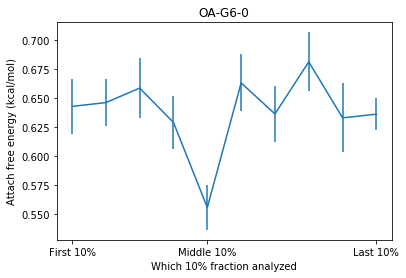

In [74]:
fig, ax = plt.subplots()
plt.errorbar(data[:, 0], data[:, 1], yerr=data[:, 2])
plt.ylabel('Attach free energy (kcal/mol)')
plt.xlabel('Which 10% fraction analyzed')
plt.xticks([0, 0.4, 0.9])
ax.set_xticklabels(['First 10%', 'Middle 10%', 'Last 10%'])
plt.title("OA-G6-0")

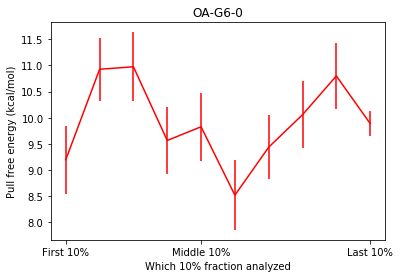

In [75]:
fig, ax = plt.subplots()
plt.errorbar(data[:, 0], data[:, 3], yerr=data[:, 4], c='r')
plt.ylabel('Pull free energy (kcal/mol)')
plt.xlabel('Which 10% fraction analyzed')
plt.xticks([0, 0.4, 0.9])
ax.set_xticklabels(['First 10%', 'Middle 10%', 'Last 10%'])
plt.title("OA-G6-0")